In [1]:
import pandas as pd
import numpy as np
from numpy import concatenate
from pandas import concat
from pandas import read_csv
from pandas import DataFrame
import tensorflow as tf
from tensorflow import keras
import os
import datetime
import IPython
import IPython.display
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Flatten, LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, Input, Reshape, RepeatVector, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
%matplotlib inline
from scipy.stats import randint as sp_randint
np.random.seed(123) # for reproducibility
import warnings
warnings.filterwarnings('ignore')

In [2]:
datos = read_csv('Barrancabermeja_Lags.csv', encoding='latin-1', sep=";")

# Se eliminan las columnas de las variables que No se van a utilizar
datos = datos.drop(['Municipio', 'Año', 'Semana_Epi',
       'Temp_Seca_Max_Dia_Prom', 'Temp_Seca_Max_Dia_Prom_1',
       'Temp_Seca_Max_Dia_Prom_2', 'Temp_Seca_Max_Dia_Prom_3',
       'Temp_Seca_Max_Dia_Prom_4', 'Temp_Seca_Max_Dia_Prom_5',
       'Temp_Seca_Max_Dia_Prom_6', 'Temp_Seca_Max_Sem', 'Temp_Seca_Max_Sem_1',
       'Temp_Seca_Max_Sem_2', 'Temp_Seca_Max_Sem_3', 'Temp_Seca_Max_Sem_4',
       'Temp_Seca_Max_Sem_5', 'Temp_Seca_Max_Sem_6', 'Temp_Seca_Min_Dia_Prom',
       'Temp_Seca_Min_Dia_Prom_1', 'Temp_Seca_Min_Dia_Prom_4',
       'Temp_Seca_Min_Dia_Prom_5', 'Temp_Seca_Min_Sem', 'Temp_Seca_Min_Sem_1', 'Temp_Seca_Min_Sem_2',
       'Temp_Seca_Min_Sem_3', 'Temp_Seca_Min_Sem_4', 'Temp_Seca_Min_Sem_5',
       'Temp_Seca_Min_Sem_6', 'Prom_Dia_Preci', 'Prom_Dia_Preci_1',
       'Prom_Dia_Preci_2', 'Prom_Dia_Preci_3', 'Prom_Dia_Preci_4',
       'Prom_Dia_Preci_5', 'Prom_Dia_Preci_6', 'Total_Preci_Sem',
       'Total_Preci_Sem_1', 'Total_Preci_Sem_2', 'Total_Preci_Sem_3',
       'Total_Preci_Sem_4', 'Total_Preci_Sem_5', 'Total_Preci_Sem_6',
       'Temp_Max_Dia_Prom', 'Temp_Max_Dia_Prom_1', 'Temp_Max_Dia_Prom_2',
       'Temp_Max_Dia_Prom_3', 'Temp_Max_Dia_Prom_4', 'Temp_Max_Dia_Prom_5',
       'Temp_Max_Dia_Prom_6', 'Temp_Max_Sem', 'Temp_Max_Sem_1',
       'Temp_Max_Sem_2', 'Temp_Max_Sem_3', 'Temp_Max_Sem_4', 'Temp_Max_Sem_5',
       'Temp_Max_Sem_6', 'Temp_Min_Dia_Prom', 'Temp_Min_Dia_Prom_1',
       'Temp_Min_Dia_Prom_2', 'Temp_Min_Dia_Prom_3', 'Temp_Min_Dia_Prom_4',
       'Temp_Min_Dia_Prom_5', 'Temp_Min_Dia_Prom_6', 'Temp_Min_Sem',
       'Temp_Min_Sem_1', 'Temp_Min_Sem_2', 'Temp_Min_Sem_3', 'Temp_Min_Sem_4',
       'Temp_Min_Sem_5', 'Temp_Min_Sem_6', 'Hum_Rel_Max', 'Hum_Rel_Max_1',
       'Hum_Rel_Max_2', 'Hum_Rel_Max_3', 'Hum_Rel_Max_4', 'Hum_Rel_Max_5',
       'Hum_Rel_Max_6','Hum_Rel_Min_1', 'Hum_Rel_Min_2',
       'Hum_Rel_Min_3', 'Hum_Rel_Min_5','Temp_Seca_Min_Dia_Prom_3', 'Temp_Seca_Min_Dia_Prom_6',
                   'Temp_Seca_Min_Dia_Prom_2', 'Hum_Rel_Min'],axis=1)
datos.columns

Index(['Casos_Dengue', 'Hum_Rel_Min_4', 'Hum_Rel_Min_6'], dtype='object')

In [3]:
datos.isnull().sum()

Casos_Dengue      0
Hum_Rel_Min_4    28
Hum_Rel_Min_6    28
dtype: int64

In [4]:
#Se realiza la imputación de los datos
knnImputer = KNNImputer (missing_values=np.nan, n_neighbors=2, 
                         weights="uniform", metric="nan_euclidean")
# Ajustamos el modelo e imputamos los missing values
knnImputer.fit(datos[['Hum_Rel_Min_4']])
datos['Hum_Rel_Min_4'] = knnImputer.transform(datos[['Hum_Rel_Min_4']]).ravel()
knnImputer.fit(datos[['Hum_Rel_Min_6']])
datos['Hum_Rel_Min_6'] = knnImputer.transform(datos[['Hum_Rel_Min_6']]).ravel()

datos.shape

(624, 3)

In [5]:
train_size = int(len(datos) * 0.7)
test_size = len(datos) - train_size
train, test = datos.iloc[0:train_size], datos.iloc[train_size:len(datos)]
print(len(train), len(test))

436 188


In [6]:
f_columns = ['Hum_Rel_Min_4', 'Hum_Rel_Min_6']
f_transformer = MinMaxScaler(feature_range=(0, 1))
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())

In [7]:
dengue_transformer = MinMaxScaler(feature_range=(0, 1))
dengue_transformer = dengue_transformer.fit(train[['Casos_Dengue']])
train['Casos_Dengue'] = dengue_transformer.transform(train[['Casos_Dengue']])
test['Casos_Dengue'] = dengue_transformer.transform(test[['Casos_Dengue']])

In [8]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [9]:
time_steps = 7
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.Casos_Dengue, time_steps)
X_test, y_test = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape )

(429, 7, 3) (429,) (181, 7, 3) (181,)


In [10]:
Barr_MLP_model_1 = keras.Sequential()

# CAPA DE ENTRADA
Barr_MLP_model_1.add(keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))

    
Barr_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Barr_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Barr_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Barr_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Barr_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Barr_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Barr_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))

#CAPA DE SALIDA

Barr_MLP_model_1.add(keras.layers.Dense(1))


#COMPILACIÓN DEL MODELO
Barr_MLP_model_1.compile(optimizer="adam", loss = 'mse')


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Barr_MLP_model_4.h5'
checkpoint = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_MLP = Barr_MLP_model_1.fit(X_train,y_train, validation_data=(X_test,y_test), 
                                     verbose=2, epochs=100, callbacks=[monitor, checkpoint],shuffle=False)
Barr_MLP_model_1.load_weights(model_filepath)

Epoch 1/100
14/14 - 2s - loss: 0.1382 - val_loss: 0.0243 - 2s/epoch - 145ms/step
Epoch 2/100
14/14 - 0s - loss: 0.0674 - val_loss: 0.0489 - 79ms/epoch - 6ms/step
Epoch 3/100
14/14 - 0s - loss: 0.0308 - val_loss: 0.0088 - 142ms/epoch - 10ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0115 - val_loss: 0.0043 - 157ms/epoch - 11ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0108 - val_loss: 0.0036 - 141ms/epoch - 10ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0107 - val_loss: 0.0032 - 173ms/epoch - 12ms/step
Epoch 7/100
14/14 - 0s - loss: 0.0106 - val_loss: 0.0030 - 172ms/epoch - 12ms/step
Epoch 8/100
14/14 - 0s - loss: 0.0107 - val_loss: 0.0028 - 262ms/epoch - 19ms/step
Epoch 9/100
14/14 - 0s - loss: 0.0108 - val_loss: 0.0027 - 174ms/epoch - 12ms/step
Epoch 10/100
14/14 - 0s - loss: 0.0111 - val_loss: 0.0027 - 125ms/epoch - 9ms/step
Epoch 11/100
14/14 - 0s - loss: 0.0117 - val_loss: 0.0028 - 79ms/epoch - 6ms/step


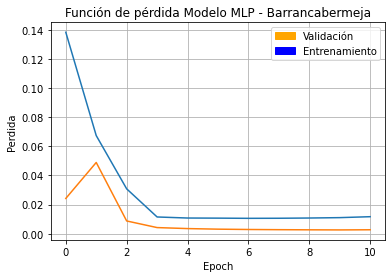

In [11]:
plt.figure(figsize=(6,4))
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo MLP - Barrancabermeja')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_MLP.history['loss'])
plt.plot(history_MLP.history['val_loss'])
plt.show()

In [12]:
y_pred = Barr_MLP_model_1.predict(X_test)
y_train_inv = dengue_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = dengue_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = dengue_transformer.inverse_transform(y_pred.reshape(1, -1))
print(y_train_inv.shape)
print(y_test_inv.shape)
print(y_pred_inv.shape)

6/6 [==============================] - 0s 2ms/step
(1, 429)
(1, 181)
(1, 181)


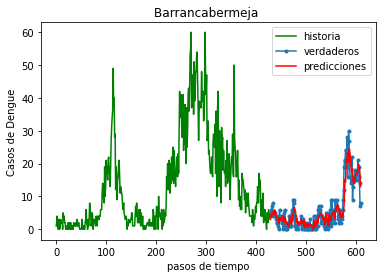

In [13]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="historia")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="verdaderos")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="predicciones")
plt.title('Barrancabermeja ')
plt.ylabel('Casos de Dengue')
plt.xlabel('pasos de tiempo')
plt.legend()
plt.show();

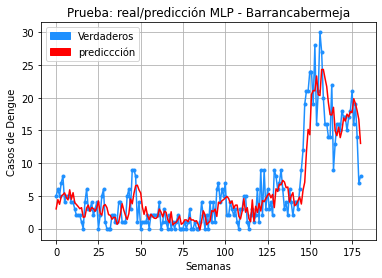

In [18]:
plt.title('Prueba: real/predicción MLP - Barrancabermeja' )
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.plot(y_test_inv.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv.flatten(), color= 'red', label="prediccción")
plt.grid(True)
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.show()

In [15]:
score = np.sqrt(metrics.mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print("RMSE  Barranca       : {}".format(score))
print("MSE Barranca  = ", mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print("MAE Barranca = ", mean_absolute_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print("r2_score Barranca  = ", r2_score(y_test_inv.flatten(), y_pred_inv.flatten()))
print("explained_variance_score Barranca  = ", explained_variance_score(y_test_inv.flatten(), y_pred_inv.flatten()))

RMSE  Barranca       : 3.0979430176675216
MSE Barranca  =  9.59725094071495
MAE Barranca =  2.2310995945285037
r2_score Barranca  =  0.7798577421488838
explained_variance_score Barranca  =  0.7799115234077826


In [16]:
# VISUALIZACIÓN DE LOS VALORES TESTEADOS VS LAS PREDICCIONES

resultados = pd.DataFrame({ 'Actuales':y_test_inv.flatten(), 'Predicciones': y_pred_inv.flatten()})
resultados['diferencia'] = resultados['Predicciones'] - resultados['Actuales']
resultados.head(60)

,Actuales,Predicciones,diferencia
0,5.0,3.009168,-1.990832
1,6.0,4.424202,-1.575798
2,5.0,3.714022,-1.285978
3,7.0,4.935044,-2.064956
4,8.0,5.174799,-2.825201
5,4.0,5.459570,1.459570
6,5.0,4.743575,-0.256425
7,5.0,4.380943,-0.619057
8,5.0,5.921276,0.921276
9,4.0,4.478330,0.478330


In [17]:
resultados.tail(60)

,Actuales,Predicciones,diferencia
121,9.0,2.690392,-6.309608
122,2.0,4.286280,2.286280
123,9.0,4.101712,-4.898288
124,3.0,4.578627,1.578627
125,6.0,5.073149,-0.926851
126,3.0,5.378540,2.378540
127,4.0,4.701103,0.701103
128,2.0,5.213363,3.213363
129,9.0,3.204745,-5.795255
130,8.0,6.080850,-1.919150
